# Openclassrooms PJ5 : Online Retail dataset :  modelisation notebook 

In [207]:
%matplotlib inline

#%load_ext autoreload  # Autoreload has a bug : when you modify function in source code and run again, python kernel hangs :(
#%autoreload 2

import datetime as dt

import sys, importlib

from functions import *
importlib.reload(sys.modules['functions'])

import pandas as pd

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

import datetime as dt

import os
import zipfile
import urllib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import qgrid

import glob

from pandas.plotting import scatter_matrix

from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.model_selection import GridSearchCV

from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import entropy

DATA_PATH = os.path.join("datasets", "onlineretail")
DATA_PATH = os.path.join(DATA_PATH, "out")

DATA_PATH_FILE_INPUT = os.path.join(DATA_PATH, "OnlineRetail_transformed.csv")


ALL_FEATURES = []

#MODEL_FEATURES=['InvoiceNo', 'InvoiceDate', 'CustomerID', 'TotalPrice', 'DescriptionNormalized', 'InvoiceMonth', 'StockCode']
MODEL_CLIENT_FEATURES = ['TotalPricePerMonth', 'DescriptionNormalized', 'HasEverCancelled', 'BoughtTopValueProduct' ]

plt.rcParams["figure.figsize"] = [16,9] # Taille par défaut des figures de matplotlib

import seaborn as sns
sns.set()

#import common_functions

####### Paramètres pour sauver et restaurer les modèles :
import pickle
####### Paramètres à changer par l'utilisateur selon son besoin :

RECOMPUTE_GRIDSEARCH = True  # CAUTION : computation is several hours long
SAVE_GRID_RESULTS = False # If True : grid results object will be saved to pickle files that have GRIDSEARCH_FILE_PREFIX
LOAD_GRID_RESULTS = False # If True : grid results object will be loaded from pickle files that have GRIDSEARCH_FILE_PREFIX
                          # Grid search results are loaded with full samples (SAMPLED_DATA must be False)

'''
RECOMPUTE_GRIDSEARCH = True  # CAUTION : computation is several hours long
SAVE_GRID_RESULTS = True # If True : grid results object will be saved to pickle files that have GRIDSEARCH_FILE_PREFIX
LOAD_GRID_RESULTS = False # If True : grid results object will be loaded from pickle files that have GRIDSEARCH_FILE_PREFIX
'''
#GRIDSEARCH_CSV_FILE = 'grid_search_results.csv'

GRIDSEARCH_FILE_PREFIX = 'grid_search_results_'

EXECUTE_INTERMEDIATE_MODELS = True # If True: every intermediate model (which results are manually analyzed in the notebook) will be executed


# Necessary for predictors used in the notebook :
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import PolynomialFeatures

### For progress bar :
from tqdm import tqdm_notebook as tqdm

# Statsmodel : 
import statsmodels.formula.api as smf

import statsmodels.api as sm
from scipy import stats

SAVE_API_MODEL = True # If True : API model ill be saved
API_MODEL_PICKLE_FILE = 'API_model_PJ5.pickle'


# Load data

In [2]:
df = load_data(DATA_PATH_FILE_INPUT)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399912 entries, 0 to 399911
Data columns (total 11 columns):
InvoiceNo                399912 non-null object
StockCode                399912 non-null object
Description              399912 non-null object
Quantity                 399912 non-null int64
InvoiceDate              399912 non-null object
UnitPrice                399912 non-null float64
CustomerID               399912 non-null object
Country                  399912 non-null object
TotalPrice               399912 non-null float64
DescriptionNormalized    399912 non-null object
InvoiceMonth             399912 non-null object
dtypes: float64(2), int64(1), object(8)
memory usage: 33.6+ MB


In [4]:
df, df_train, df_test = custom_train_test_split_sample(df, 'TotalPrice')

In [5]:
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359920 entries, 0 to 359919
Data columns (total 12 columns):
index                    359920 non-null int64
InvoiceNo                359920 non-null object
StockCode                359920 non-null object
Description              359920 non-null object
Quantity                 359920 non-null int64
InvoiceDate              359920 non-null object
UnitPrice                359920 non-null float64
CustomerID               359920 non-null object
Country                  359920 non-null object
TotalPrice               359920 non-null float64
DescriptionNormalized    359920 non-null object
InvoiceMonth             359920 non-null object
dtypes: float64(2), int64(2), object(8)
memory usage: 33.0+ MB


In [7]:
df_train_ori = df_train.copy(deep=True)
df_test_ori = df_test.copy(deep=True)

# Top value products (must be saved with the model, and passed to it)

In [8]:
df_nocancel = df_train[df_train['InvoiceNo'].str.startswith('C') == False]
df_nocancel.reset_index(inplace=True)

df_gbproduct = df_nocancel[['StockCode', 'TotalPrice']].groupby('StockCode').sum()['TotalPrice']

In [9]:
TOP_VALUE_PRODUCT_THRESHOLD = 20
top_value_products = df_gbproduct.sort_values(ascending=False).head(TOP_VALUE_PRODUCT_THRESHOLD).index  # Get top value products

In [10]:
top_value_products

Index(['23843', '22423', '85123A', '23166', '85099B', '47566', '84879',
       '23084', '79321', '21137', '22386', '22086', '23203', '23298', '22197',
       '22720', '82484', '22960', '23284', '22470'],
      dtype='object', name='StockCode')

# Preparation pipeline : model with bow features + TotalPricePerMonth + BoughtTopValueProduct + HasEverCancelled

In [11]:
importlib.reload(sys.modules['functions'])
from functions import *

In [12]:
df_train = df_train_ori
df_test = df_test_ori


In [13]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='PCA', n_dim=200)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [14]:
df_train = preparation_pipeline.fit_transform(df_train)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Fit log scaler multiple
Transform log scaler scaler multiple
Fit Min max scaler multiple
Transform Min max scaler multiple
Fit Dimensionality Reductor
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_woodland', 'DescriptionNormalized_word',
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNo

In [15]:
df_test = preparation_pipeline.transform(df_test)

Transform data
Transform log scaler scaler multiple
Transform Min max scaler multiple
Transform Dimensionality Reductor
Remaining columns: ['HasEverCancelled', 'TotalPricePerMonth', 'BoughtTopValueProduct']
Transform Min max scaler multiple


In [16]:
df_train

,HasEverCancelled,TotalPricePerMonth,BoughtTopValueProduct,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,...,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,1.0,0.877446,1.0,0.012337,0.471255,0.453895,0.473793,0.422515,0.477429,0.511299,0.621572,0.503608,0.457640,0.488112,0.409851,0.507055,0.489921,0.535112,0.450099,0.416215,0.433678,0.443110,0.493113,0.412216,0.427219,0.473200,0.432093,0.528716,0.450216,0.459646,0.473048,0.433343,0.488316,0.503164,0.400001,0.584752,0.447438,0.492680,0.517258,0.377823,0.529196,0.459107,0.522877,0.469436,0.504345,0.398998,0.543020,0.429231,0.399796,0.521639,0.542991,0.448954,0.417234,0.431461,0.490515,0.542840,0.510726,0.361016,0.548764,0.425436,0.511753,0.375066,0.496324,0.476174,0.439224,0.479767,0.588310,0.490040,0.387545,0.504146,0.392999,0.414502,0.441010,0.517937,0.472613,0.505581,0.468415,0.561348,0.453965,0.443811,0.579750,0.507491,0.505162,0.522384,0.451964,0.505444,0.475669,0.463194,0.471138,0.428941,0.563994,0.521804,0.501732,0.519740,0.545807,0.399515,0.479424,0.457360,0.552891,0.552132,...,0.442018,0.483510,0.469831,0.555451,0.443640,0.460402,0.409701,0.402955,0.456778,0.516249,0.550767,0.487019,0.398862,0.539100,0.477272,0.455610,0.464136,0.523741,0.486981,0.566659,0.505569,0.421420,0.513580,0.501915,0.431075,0.385072,0.515873,0.499203,0.474613,0.491329,0.545118,0.483152,0.405556,0.417222,0.451988,0.429414,0.505369,0.456888,0.459098,0.492647,0.470510,0.473318,0.407703,0.528234,0.394184,0.417409,0.541471,0.492482,0.453582,0.465603,0.536188,0.409500,0.504954,0.516265,0.484865,0.436857,0.461494,0.485801,0.449288,0.498698,0.494678,0.451859,0.498233,0.463871,0.497176,0.441874,0.495599,0.496479,0.473444,0.542502,0.405203,0.462586,0.430358,0.454841,0.475705,0.448130,0.455027,0.470148,0.508721,0.432294,0.442117,0.450248,0.493644,0.469007,0.445338,0.458374,0.439820,0.449906,0.448205,0.422928,0.475765,0.498462,0.503171,0.520138,0.472351,0.472280,0.456871,0.499050,0.426913,0.469152
1,0.0,0.572415,1.0,0.356103,0.422611,0.371563,0.401206,0.423753,0.459668,0.244695,0.315718,0.324960,0.332577,0.361417,0.446315,0.447542,0.669783,0.790501,0.482164,0.576499,0.752753,0.562993,0.737260,0.470347,0.526157,0.381711,0.560419,0.457615,0.378896,0.394295,0.411293,0.531512,0.580637,0.551046,0.628213,0.473105,0.278695,0.419523,0.597281,0.559024,0.443982,0.486082,0.722544,0.536351,0.164852,0.375486,0.309871,0.571661,0.698559,0.419709,0.153834,0.769936,0.479798,0.650844,0.708143,0.469520,0.160116,0.626756,0.241120,0.358433,0.175175,0.410170,0.425278,0.679632,0.586536,0.522301,0.216822,0.632546,0.435146,0.768242,0.189217,0.355839,0.654483,0.836649,0.607627,0.416430,0.516677,0.243001,0.434406,0.592316,0.654916,0.422913,0.263274,0.487074,0.670438,0.066970,0.270752,0.346566,0.575380,0.687143,0.492310,0.405124,0.750466,0.503628,0.536841,0.306648,0.277527,0.640288,0.915704,0.427103,...,0.367640,0.309116,0.430368,0.614321,0.314971,0.423737,0.557158,0.388584,0.425230,0.503176,0.625818,0.175598,0.461695,0.402608,0.594853,0.414315,0.377087,0.565383,0.599207,0.483363,0.419228,0.439874,0.485338,0.441777,0.559043,0.463116,0.505877,0.291369,0.396165,0.481025,0.518890,0.620306,0.450874,0.694173,0.575584,0.370280,0.169377,0.525288,0.588152,0.363670,0.649533,0.520457,0.494832,0.719235,0.000690,0.522935,0.383923,0.424693,0.163552,0.523089,0.312567,0.472744,0.300414,0.124269,0.497302,0.415230,0.467584,0.328565,0.538658,0.747308,0.404553,0.737778,0.5772

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4332 entries, 0 to 4331
Columns: 203 entries, HasEverCancelled to 199
dtypes: float64(203)
memory usage: 6.7 MB


# Explained variance of bag of words features

In [18]:
from display_factorial import *
importlib.reload(sys.modules['display_factorial'])

<module 'display_factorial' from '/home/francois/coding/OC/PJ5/display_factorial.py'>

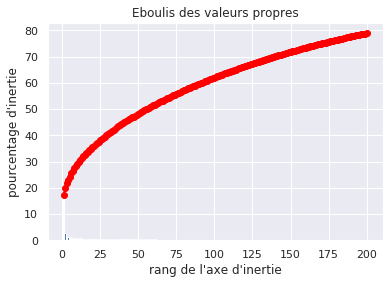

In [19]:
display_scree_plot(preparation_pipeline['dimensionality_reductor'].reductor)

# 2D visualization

In [20]:
pca = PCA(n_components=2, random_state=42)
X_transformed = pca.fit_transform(df_train)
X_test_transformed = pca.fit_transform(df_test)

In [21]:
X_transformed[:,1]

array([ 0.24713579, -0.48030475,  0.28160928, ...,  0.22862045,
       -0.46101208,  0.28627625])

In [22]:
print('Binarisation of color categories')
bins = [-np.inf,df_train['TotalPricePerMonth'].quantile(0.25),\
        df_train['TotalPricePerMonth'].quantile(0.50),\
        df_train['TotalPricePerMonth'].quantile(0.75),\
        df_train['TotalPricePerMonth'].quantile(1)]

labels = [0, 1, 2, 3]

df_score_cat_train = pd.cut(df_train['TotalPricePerMonth'], bins=bins, labels=labels)


bins = [-np.inf,df_test['TotalPricePerMonth'].quantile(0.25),\
        df_test['TotalPricePerMonth'].quantile(0.50),\
        df_test['TotalPricePerMonth'].quantile(0.75),\
        df_test['TotalPricePerMonth'].quantile(1)]

labels = [0, 1, 2, 3]

df_score_cat_test = pd.cut(df_test['TotalPricePerMonth'], bins=bins, labels=labels)

Binarisation of color categories


Text(0, 0.5, 'Axe 2')

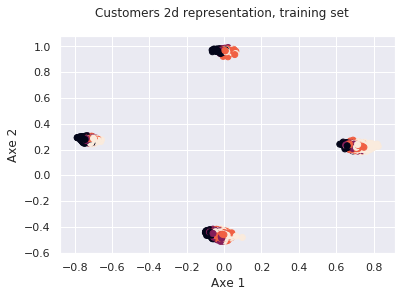

In [23]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [24]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients.html') 

'clusters_plot_clients.html'

Text(0, 0.5, 'Axe 2')

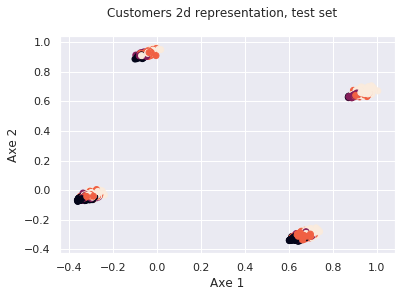

In [25]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, test set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_test_transformed[:,0], X_test_transformed[:,1], c=df_score_cat_test)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

# Model with only bag of word features

In [26]:
importlib.reload(sys.modules['functions'])
from functions import *

In [27]:
df_train = df_train_ori
df_test = df_test_ori


In [28]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    #('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    #('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='PCA', n_dim=200)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [29]:
df_train = preparation_pipeline.fit_transform(df_train)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_woodland', 'DescriptionNormalized_word',
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNormalized_your', 'DescriptionNormalized_zinc'],
      dtype='object', length=601)
Fit Dimensionality Reductor
Features selected (in order): Index(['Desc

In [30]:
df_test = preparation_pipeline.transform(df_test)

Transform data
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_woodland', 'DescriptionNormalized_word',
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNormalized_your', 'DescriptionNormalized_zinc'],
      dtype='object', length=601)
Transform Dimensionality Reductor
Remaining columns: []
Transform Min max scaler multiple


In [31]:
df_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,0.012337,0.471255,0.453895,0.473793,0.422515,0.477429,0.511299,0.621572,0.503608,0.457640,0.488112,0.409851,0.507055,0.489921,0.535112,0.450099,0.416215,0.433678,0.443110,0.493113,0.412216,0.427219,0.473200,0.432093,0.528716,0.450216,0.459646,0.473048,0.433343,0.488316,0.503164,0.400001,0.584752,0.447438,0.492680,0.517258,0.377823,0.529196,0.459107,0.522877,0.469436,0.504345,0.398998,0.543020,0.429231,0.399796,0.521639,0.542991,0.448954,0.417234,0.431461,0.490515,0.542840,0.510726,0.361016,0.548764,0.425436,0.511753,0.375066,0.496324,0.476174,0.439224,0.479767,0.588310,0.490040,0.387545,0.504146,0.392999,0.414502,0.441010,0.517937,0.472613,0.505581,0.468415,0.561348,0.453965,0.443811,0.579750,0.507491,0.505162,0.522384,0.451964,0.505444,0.475669,0.463194,0.471138,0.428941,0.563994,0.521804,0.501732,0.519740,0.545807,0.399515,0.479424,0.457360,0.552891,0.552132,0.498420,0.459838,0.508824,0.442018,0.483510,0.469831,0.555451,0.443640,0.460402,0.409701,0.402955,0.456778,0.516249,0.550767,0.487019,0.398862,0.539100,0.477272,0.455610,0.464136,0.523741,0.486981,0.566659,0.505569,0.421420,0.513580,0.501915,0.431075,0.385072,0.515873,0.499203,0.474613,0.491329,0.545118,0.483152,0.405556,0.417222,0.451988,0.429414,0.505369,0.456888,0.459098,0.492647,0.470510,0.473318,0.407703,0.528234,0.394184,0.417409,0.541471,0.492482,0.453582,0.465603,0.536188,0.409500,0.504954,0.516265,0.484865,0.436857,0.461494,0.485801,0.449288,0.498698,0.494678,0.451859,0.498233,0.463871,0.497176,0.441874,0.495599,0.496479,0.473444,0.542502,0.405203,0.462586,0.430358,0.454841,0.475705,0.448130,0.455027,0.470148,0.508721,0.432294,0.442117,0.450248,0.493644,0.469007,0.445338,0.458374,0.439820,0.449906,0.448205,0.422928,0.475765,0.498462,0.503171,0.520138,0.472351,0.472280,0.456871,0.499050,0.426913,0.469152
1,0.356103,0.422611,0.371563,0.401206,0.423753,0.459668,0.244695,0.315718,0.324960,0.332577,0.361417,0.446315,0.447542,0.669783,0.790501,0.482164,0.576499,0.752753,0.562993,0.737260,0.470347,0.526157,0.381711,0.560419,0.457615,0.378896,0.394295,0.411293,0.531512,0.580637,0.551046,0.628213,0.473105,0.278695,0.419523,0.597281,0.559024,0.443982,0.486082,0.722544,0.536351,0.164852,0.375486,0.309871,0.571661,0.698559,0.419709,0.153834,0.769936,0.479798,0.650844,0.708143,0.469520,0.160116,0.626756,0.241120,0.358433,0.175175,0.410170,0.425278,0.679632,0.586536,0.522301,0.216822,0.632546,0.435146,0.768242,0.189217,0.355839,0.654483,0.836649,0.607627,0.416430,0.516677,0.243001,0.434406,0.592316,0.654916,0.422913,0.263274,0.487074,0.670438,0.066970,0.270752,0.346566,0.575380,0.687143,0.492310,0.405124,0.750466,0.503628,0.536841,0.306648,0.277527,0.640288,0.915704,0.427103,0.335526,0.349815,0.434827,0.367640,0.309116,0.430368,0.614321,0.314971,0.423737,0.557158,0.388584,0.425230,0.503176,0.625818,0.175598,0.461695,0.402608,0.594853,0.414315,0.377087,0.565383,0.599207,0.483363,0.419228,0.439874,0.485338,0.441777,0.559043,0.463116,0.505877,0.291369,0.396165,0.481025,0.518890,0.620306,0.450874,0.694173,0.575584,0.370280,0.169377,0.525288,0.588152,0.363670,0.649533,0.520457,0.494832,0.719235,0.000690,0.522935,0.383923,0.424693,0.163552,0.523089,0.312567,0.472744,0.300414,0.124269,0.497302,0.415230,0.467584,0.328565,0.538658,0.747308,0.404553,0.737778,0.577275,0.317186,0.503786,0.313948,0.664353,0.

In [32]:
pca = PCA(n_components=2, random_state=42)
X_transformed = pca.fit_transform(df_train)
X_test_transformed = pca.fit_transform(df_test)

Text(0, 0.5, 'Axe 2')

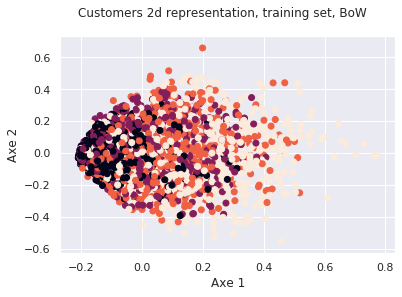

In [33]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set, BoW')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [34]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_score_cat_train,
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_onlybow.html') 

'clusters_plot_clients_onlybow.html'

# Model with bow features + TotalPricePerMonth

In [35]:
importlib.reload(sys.modules['functions'])
from functions import *

In [36]:
df_train = df_train_ori
df_test = df_test_ori


In [37]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    #('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    #('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized', 'TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='PCA', n_dim=200)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [38]:
df_train = preparation_pipeline.fit_transform(df_train)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_word', 'DescriptionNormalized_world',
       'DescriptionNormalized_wrap', 'DescriptionNormalized_wreath',
       'DescriptionNormalized_writing', 'DescriptionNormalized_yellow',
       'DescriptionNormalized_you', 'DescriptionNormalized_your',
       'DescriptionNormalized_zinc', 'TotalPricePerMonth'],
      dtype='object', length=602)
Fit Dimensionality Reductor
Features selected (in order): Index(['DescriptionNorma

In [39]:
df_test = preparation_pipeline.transform(df_test)

Transform data
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_word', 'DescriptionNormalized_world',
       'DescriptionNormalized_wrap', 'DescriptionNormalized_wreath',
       'DescriptionNormalized_writing', 'DescriptionNormalized_yellow',
       'DescriptionNormalized_you', 'DescriptionNormalized_your',
       'DescriptionNormalized_zinc', 'TotalPricePerMonth'],
      dtype='object', length=602)
Transform Dimensionality Reductor
Remaining columns: ['TotalPricePerMonth']
Transform Min max scaler multiple


In [40]:
df_train

,TotalPricePerMonth,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,...,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,0.289049,0.012337,0.471255,0.453895,0.473793,0.422515,0.477429,0.511299,0.621572,0.503608,0.457640,0.488112,0.409851,0.507055,0.489921,0.535112,0.450099,0.416215,0.433678,0.443110,0.493113,0.412216,0.427219,0.473200,0.432093,0.528716,0.450216,0.459646,0.473048,0.433343,0.488316,0.503164,0.400001,0.584752,0.447438,0.492680,0.517258,0.377823,0.529196,0.459107,0.522877,0.469436,0.504345,0.398998,0.543020,0.429231,0.399796,0.521639,0.542991,0.448954,0.417234,0.431461,0.490515,0.542840,0.510726,0.361016,0.548764,0.425436,0.511753,0.375066,0.496324,0.476174,0.439224,0.479767,0.588310,0.490040,0.387545,0.504146,0.392999,0.414502,0.441010,0.517937,0.472613,0.505581,0.468415,0.561348,0.453965,0.443811,0.579750,0.507491,0.505162,0.522384,0.451964,0.505444,0.475669,0.463194,0.471138,0.428941,0.563994,0.521804,0.501732,0.519740,0.545807,0.399515,0.479424,0.457360,0.552891,0.552132,0.498420,0.459838,...,0.442018,0.483510,0.469831,0.555451,0.443640,0.460402,0.409701,0.402955,0.456778,0.516249,0.550767,0.487019,0.398862,0.539100,0.477272,0.455610,0.464136,0.523741,0.486981,0.566659,0.505569,0.421420,0.513580,0.501915,0.431075,0.385072,0.515873,0.499203,0.474613,0.491329,0.545118,0.483152,0.405556,0.417222,0.451988,0.429414,0.505369,0.456888,0.459098,0.492647,0.470510,0.473318,0.407703,0.528234,0.394184,0.417409,0.541471,0.492482,0.453582,0.465603,0.536188,0.409500,0.504954,0.516265,0.484865,0.436857,0.461494,0.485801,0.449288,0.498698,0.494678,0.451859,0.498233,0.463871,0.497176,0.441874,0.495599,0.496479,0.473444,0.542502,0.405203,0.462586,0.430358,0.454841,0.475705,0.448130,0.455027,0.470148,0.508721,0.432294,0.442117,0.450248,0.493644,0.469007,0.445338,0.458374,0.439820,0.449906,0.448205,0.422928,0.475765,0.498462,0.503171,0.520138,0.472351,0.472280,0.456871,0.499050,0.426913,0.469152
1,0.013128,0.356103,0.422611,0.371563,0.401206,0.423753,0.459668,0.244695,0.315718,0.324960,0.332577,0.361417,0.446315,0.447542,0.669783,0.790501,0.482164,0.576499,0.752753,0.562993,0.737260,0.470347,0.526157,0.381711,0.560419,0.457615,0.378896,0.394295,0.411293,0.531512,0.580637,0.551046,0.628213,0.473105,0.278695,0.419523,0.597281,0.559024,0.443982,0.486082,0.722544,0.536351,0.164852,0.375486,0.309871,0.571661,0.698559,0.419709,0.153834,0.769936,0.479798,0.650844,0.708143,0.469520,0.160116,0.626756,0.241120,0.358433,0.175175,0.410170,0.425278,0.679632,0.586536,0.522301,0.216822,0.632546,0.435146,0.768242,0.189217,0.355839,0.654483,0.836649,0.607627,0.416430,0.516677,0.243001,0.434406,0.592316,0.654916,0.422913,0.263274,0.487074,0.670438,0.066970,0.270752,0.346566,0.575380,0.687143,0.492310,0.405124,0.750466,0.503628,0.536841,0.306648,0.277527,0.640288,0.915704,0.427103,0.335526,0.349815,...,0.367640,0.309116,0.430368,0.614321,0.314971,0.423737,0.557158,0.388584,0.425230,0.503176,0.625818,0.175598,0.461695,0.402608,0.594853,0.414315,0.377087,0.565383,0.599207,0.483363,0.419228,0.439874,0.485338,0.441777,0.559043,0.463116,0.505877,0.291369,0.396165,0.481025,0.518890,0.620306,0.450874,0.694173,0.575584,0.370280,0.169377,0.525288,0.588152,0.363670,0.649533,0.520457,0.494832,0.719235,0.000690,0.522935,0.383923,0.424693,0.163552,0.523089,0.312567,0.472744,0.300414,0.124269,0.497302,0.415230,0.467584,0.328565,0.538658,0.747308,0.404553,0.737778,0.577275,0.317186,0

In [41]:
pca = PCA(n_components=2, random_state=42)
X_transformed = pca.fit_transform(df_train)
X_test_transformed = pca.fit_transform(df_test)

Text(0, 0.5, 'Axe 2')

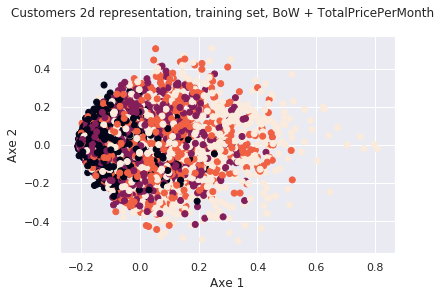

In [42]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set, BoW + TotalPricePerMonth')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [43]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_score_cat_train,
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_onlybow.html') 

'clusters_plot_clients_onlybow.html'

# Model with bow features + TotalPricePerMonth + HasEverCancelled

In [44]:
importlib.reload(sys.modules['functions'])
from functions import *

In [45]:
df_train = df_train_ori
df_test = df_test_ori


In [46]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    #('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    #('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized', 'TotalPricePerMonth', 'HasEverCancelled'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='PCA', n_dim=200)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [47]:
df_train = preparation_pipeline.fit_transform(df_train)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNormalized_your', 'DescriptionNormalized_zinc',
       'HasEverCancelled', 'TotalPricePerMonth'],
      dtype='object', length=603)
Fit Dimensionality Reductor
Features selected (in order): Index(['DescriptionNormalized_10',

In [48]:
df_test = preparation_pipeline.transform(df_test)

Transform data
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNormalized_your', 'DescriptionNormalized_zinc',
       'HasEverCancelled', 'TotalPricePerMonth'],
      dtype='object', length=603)
Transform Dimensionality Reductor
Remaining columns: ['HasEverCancelled', 'TotalPricePerMonth']
Transform Min max scaler multiple


In [49]:
df_train

,HasEverCancelled,TotalPricePerMonth,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,...,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,1.0,0.289049,0.012337,0.471255,0.453895,0.473793,0.422515,0.477429,0.511299,0.621572,0.503608,0.457640,0.488112,0.409851,0.507055,0.489921,0.535112,0.450099,0.416215,0.433678,0.443110,0.493113,0.412216,0.427219,0.473200,0.432093,0.528716,0.450216,0.459646,0.473048,0.433343,0.488316,0.503164,0.400001,0.584752,0.447438,0.492680,0.517258,0.377823,0.529196,0.459107,0.522877,0.469436,0.504345,0.398998,0.543020,0.429231,0.399796,0.521639,0.542991,0.448954,0.417234,0.431461,0.490515,0.542840,0.510726,0.361016,0.548764,0.425436,0.511753,0.375066,0.496324,0.476174,0.439224,0.479767,0.588310,0.490040,0.387545,0.504146,0.392999,0.414502,0.441010,0.517937,0.472613,0.505581,0.468415,0.561348,0.453965,0.443811,0.579750,0.507491,0.505162,0.522384,0.451964,0.505444,0.475669,0.463194,0.471138,0.428941,0.563994,0.521804,0.501732,0.519740,0.545807,0.399515,0.479424,0.457360,0.552891,0.552132,0.498420,...,0.442018,0.483510,0.469831,0.555451,0.443640,0.460402,0.409701,0.402955,0.456778,0.516249,0.550767,0.487019,0.398862,0.539100,0.477272,0.455610,0.464136,0.523741,0.486981,0.566659,0.505569,0.421420,0.513580,0.501915,0.431075,0.385072,0.515873,0.499203,0.474613,0.491329,0.545118,0.483152,0.405556,0.417222,0.451988,0.429414,0.505369,0.456888,0.459098,0.492647,0.470510,0.473318,0.407703,0.528234,0.394184,0.417409,0.541471,0.492482,0.453582,0.465603,0.536188,0.409500,0.504954,0.516265,0.484865,0.436857,0.461494,0.485801,0.449288,0.498698,0.494678,0.451859,0.498233,0.463871,0.497176,0.441874,0.495599,0.496479,0.473444,0.542502,0.405203,0.462586,0.430358,0.454841,0.475705,0.448130,0.455027,0.470148,0.508721,0.432294,0.442117,0.450248,0.493644,0.469007,0.445338,0.458374,0.439820,0.449906,0.448205,0.422928,0.475765,0.498462,0.503171,0.520138,0.472351,0.472280,0.456871,0.499050,0.426913,0.469152
1,0.0,0.013128,0.356103,0.422611,0.371563,0.401206,0.423753,0.459668,0.244695,0.315718,0.324960,0.332577,0.361417,0.446315,0.447542,0.669783,0.790501,0.482164,0.576499,0.752753,0.562993,0.737260,0.470347,0.526157,0.381711,0.560419,0.457615,0.378896,0.394295,0.411293,0.531512,0.580637,0.551046,0.628213,0.473105,0.278695,0.419523,0.597281,0.559024,0.443982,0.486082,0.722544,0.536351,0.164852,0.375486,0.309871,0.571661,0.698559,0.419709,0.153834,0.769936,0.479798,0.650844,0.708143,0.469520,0.160116,0.626756,0.241120,0.358433,0.175175,0.410170,0.425278,0.679632,0.586536,0.522301,0.216822,0.632546,0.435146,0.768242,0.189217,0.355839,0.654483,0.836649,0.607627,0.416430,0.516677,0.243001,0.434406,0.592316,0.654916,0.422913,0.263274,0.487074,0.670438,0.066970,0.270752,0.346566,0.575380,0.687143,0.492310,0.405124,0.750466,0.503628,0.536841,0.306648,0.277527,0.640288,0.915704,0.427103,0.335526,...,0.367640,0.309116,0.430368,0.614321,0.314971,0.423737,0.557158,0.388584,0.425230,0.503176,0.625818,0.175598,0.461695,0.402608,0.594853,0.414315,0.377087,0.565383,0.599207,0.483363,0.419228,0.439874,0.485338,0.441777,0.559043,0.463116,0.505877,0.291369,0.396165,0.481025,0.518890,0.620306,0.450874,0.694173,0.575584,0.370280,0.169377,0.525288,0.588152,0.363670,0.649533,0.520457,0.494832,0.719235,0.000690,0.522935,0.383923,0.424693,0.163552,0.523089,0.312567,0.472744,0.300414,0.124269,0.497302,0.415230,0.467584,0.328565,0.538658,0.747308,0.404553,0.737778,0.577275,0.3171

In [50]:
pca = PCA(n_components=2, random_state=42)
X_transformed = pca.fit_transform(df_train)
X_test_transformed = pca.fit_transform(df_test)

Text(0, 0.5, 'Axe 2')

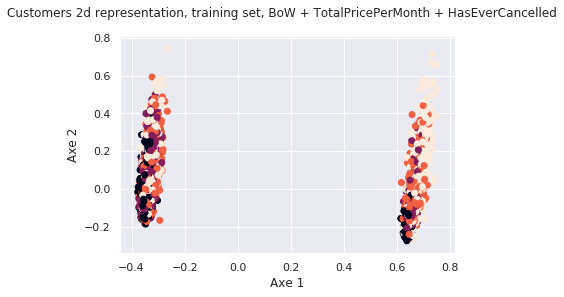

In [51]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set, BoW + TotalPricePerMonth + HasEverCancelled')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [52]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_score_cat_train,
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_onlybow.html') 

'clusters_plot_clients_onlybow.html'

# Model with all features and NCA

In [53]:
importlib.reload(sys.modules['functions'])
from functions import *

In [54]:
df_train = df_train_ori
df_test = df_test_ori

In [55]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='NCA', n_dim=200, labels_featurename='TotalPricePerMonth')),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [56]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Fit log scaler multiple
Transform log scaler scaler multiple
Fit Min max scaler multiple
Transform Min max scaler multiple
Fit Dimensionality Reductor
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_woodland', 'DescriptionNormalized_word',
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNo

In [57]:
df_train

,HasEverCancelled,TotalPricePerMonth,BoughtTopValueProduct,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,...,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,1.0,0.877446,1.0,0.012337,0.471255,0.453895,0.473793,0.422515,0.477429,0.511299,0.621572,0.503608,0.457640,0.488112,0.409851,0.507055,0.489921,0.535112,0.450099,0.416215,0.433678,0.443110,0.493113,0.412216,0.427219,0.473200,0.432093,0.528716,0.450216,0.459646,0.473048,0.433343,0.488316,0.503164,0.400001,0.584752,0.447438,0.492680,0.517258,0.377823,0.529196,0.459107,0.522877,0.469436,0.504345,0.398998,0.543020,0.429231,0.399796,0.521639,0.542991,0.448954,0.417234,0.431461,0.490515,0.542840,0.510726,0.361016,0.548764,0.425436,0.511753,0.375066,0.496324,0.476174,0.439224,0.479767,0.588310,0.490040,0.387545,0.504146,0.392999,0.414502,0.441010,0.517937,0.472613,0.505581,0.468415,0.561348,0.453965,0.443811,0.579750,0.507491,0.505162,0.522384,0.451964,0.505444,0.475669,0.463194,0.471138,0.428941,0.563994,0.521804,0.501732,0.519740,0.545807,0.399515,0.479424,0.457360,0.552891,0.552132,...,0.442018,0.483510,0.469831,0.555451,0.443640,0.460402,0.409701,0.402955,0.456778,0.516249,0.550767,0.487019,0.398862,0.539100,0.477272,0.455610,0.464136,0.523741,0.486981,0.566659,0.505569,0.421420,0.513580,0.501915,0.431075,0.385072,0.515873,0.499203,0.474613,0.491329,0.545118,0.483152,0.405556,0.417222,0.451988,0.429414,0.505369,0.456888,0.459098,0.492647,0.470510,0.473318,0.407703,0.528234,0.394184,0.417409,0.541471,0.492482,0.453582,0.465603,0.536188,0.409500,0.504954,0.516265,0.484865,0.436857,0.461494,0.485801,0.449288,0.498698,0.494678,0.451859,0.498233,0.463871,0.497176,0.441874,0.495599,0.496479,0.473444,0.542502,0.405203,0.462586,0.430358,0.454841,0.475705,0.448130,0.455027,0.470148,0.508721,0.432294,0.442117,0.450248,0.493644,0.469007,0.445338,0.458374,0.439820,0.449906,0.448205,0.422928,0.475765,0.498462,0.503171,0.520138,0.472351,0.472280,0.456871,0.499050,0.426913,0.469152
1,0.0,0.572415,1.0,0.356103,0.422611,0.371563,0.401206,0.423753,0.459668,0.244695,0.315718,0.324960,0.332577,0.361417,0.446315,0.447542,0.669783,0.790501,0.482164,0.576499,0.752753,0.562993,0.737260,0.470347,0.526157,0.381711,0.560419,0.457615,0.378896,0.394295,0.411293,0.531512,0.580637,0.551046,0.628213,0.473105,0.278695,0.419523,0.597281,0.559024,0.443982,0.486082,0.722544,0.536351,0.164852,0.375486,0.309871,0.571661,0.698559,0.419709,0.153834,0.769936,0.479798,0.650844,0.708143,0.469520,0.160116,0.626756,0.241120,0.358433,0.175175,0.410170,0.425278,0.679632,0.586536,0.522301,0.216822,0.632546,0.435146,0.768242,0.189217,0.355839,0.654483,0.836649,0.607627,0.416430,0.516677,0.243001,0.434406,0.592316,0.654916,0.422913,0.263274,0.487074,0.670438,0.066970,0.270752,0.346566,0.575380,0.687143,0.492310,0.405124,0.750466,0.503628,0.536841,0.306648,0.277527,0.640288,0.915704,0.427103,...,0.367640,0.309116,0.430368,0.614321,0.314971,0.423737,0.557158,0.388584,0.425230,0.503176,0.625818,0.175598,0.461695,0.402608,0.594853,0.414315,0.377087,0.565383,0.599207,0.483363,0.419228,0.439874,0.485338,0.441777,0.559043,0.463116,0.505877,0.291369,0.396165,0.481025,0.518890,0.620306,0.450874,0.694173,0.575584,0.370280,0.169377,0.525288,0.588152,0.363670,0.649533,0.520457,0.494832,0.719235,0.000690,0.522935,0.383923,0.424693,0.163552,0.523089,0.312567,0.472744,0.300414,0.124269,0.497302,0.415230,0.467584,0.328565,0.538658,0.747308,0.404553,0.737778,0.5772

In [58]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4332 entries, 0 to 4331
Columns: 203 entries, HasEverCancelled to 199
dtypes: float64(203)
memory usage: 6.7 MB


In [59]:
pca = PCA(n_components=2,random_state=42)
X_transformed = pca.fit_transform(df_train)
X_test_transformed = pca.fit_transform(df_test)

In [60]:
X_transformed[:,1]

array([ 0.24713579, -0.48030475,  0.28160928, ...,  0.22862045,
       -0.46101208,  0.28627625])

Text(0, 0.5, 'Axe 2')

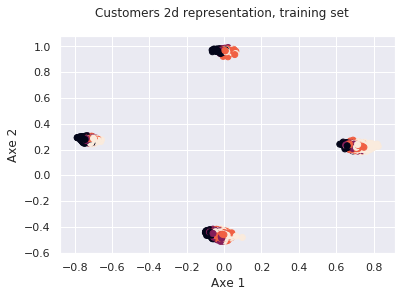

In [61]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [62]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_nca_allfeats.html') 

'clusters_plot_clients_nca_allfeats.html'

# Model with all features and NCA, final representation with tSNE

In [63]:
importlib.reload(sys.modules['functions'])
from functions import *

In [64]:
df_train = df_train_ori
df_test = df_test_ori

In [65]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='NCA', n_dim=200, labels_featurename='TotalPricePerMonth')),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [66]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Fit log scaler multiple
Transform log scaler scaler multiple
Fit Min max scaler multiple
Transform Min max scaler multiple
Fit Dimensionality Reductor
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_woodland', 'DescriptionNormalized_word',
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNo

In [67]:
df_train

,HasEverCancelled,TotalPricePerMonth,BoughtTopValueProduct,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,...,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,1.0,0.877446,1.0,0.012337,0.471255,0.453895,0.473793,0.422515,0.477429,0.511299,0.621572,0.503608,0.457640,0.488112,0.409851,0.507055,0.489921,0.535112,0.450099,0.416215,0.433678,0.443110,0.493113,0.412216,0.427219,0.473200,0.432093,0.528716,0.450216,0.459646,0.473048,0.433343,0.488316,0.503164,0.400001,0.584752,0.447438,0.492680,0.517258,0.377823,0.529196,0.459107,0.522877,0.469436,0.504345,0.398998,0.543020,0.429231,0.399796,0.521639,0.542991,0.448954,0.417234,0.431461,0.490515,0.542840,0.510726,0.361016,0.548764,0.425436,0.511753,0.375066,0.496324,0.476174,0.439224,0.479767,0.588310,0.490040,0.387545,0.504146,0.392999,0.414502,0.441010,0.517937,0.472613,0.505581,0.468415,0.561348,0.453965,0.443811,0.579750,0.507491,0.505162,0.522384,0.451964,0.505444,0.475669,0.463194,0.471138,0.428941,0.563994,0.521804,0.501732,0.519740,0.545807,0.399515,0.479424,0.457360,0.552891,0.552132,...,0.442018,0.483510,0.469831,0.555451,0.443640,0.460402,0.409701,0.402955,0.456778,0.516249,0.550767,0.487019,0.398862,0.539100,0.477272,0.455610,0.464136,0.523741,0.486981,0.566659,0.505569,0.421420,0.513580,0.501915,0.431075,0.385072,0.515873,0.499203,0.474613,0.491329,0.545118,0.483152,0.405556,0.417222,0.451988,0.429414,0.505369,0.456888,0.459098,0.492647,0.470510,0.473318,0.407703,0.528234,0.394184,0.417409,0.541471,0.492482,0.453582,0.465603,0.536188,0.409500,0.504954,0.516265,0.484865,0.436857,0.461494,0.485801,0.449288,0.498698,0.494678,0.451859,0.498233,0.463871,0.497176,0.441874,0.495599,0.496479,0.473444,0.542502,0.405203,0.462586,0.430358,0.454841,0.475705,0.448130,0.455027,0.470148,0.508721,0.432294,0.442117,0.450248,0.493644,0.469007,0.445338,0.458374,0.439820,0.449906,0.448205,0.422928,0.475765,0.498462,0.503171,0.520138,0.472351,0.472280,0.456871,0.499050,0.426913,0.469152
1,0.0,0.572415,1.0,0.356103,0.422611,0.371563,0.401206,0.423753,0.459668,0.244695,0.315718,0.324960,0.332577,0.361417,0.446315,0.447542,0.669783,0.790501,0.482164,0.576499,0.752753,0.562993,0.737260,0.470347,0.526157,0.381711,0.560419,0.457615,0.378896,0.394295,0.411293,0.531512,0.580637,0.551046,0.628213,0.473105,0.278695,0.419523,0.597281,0.559024,0.443982,0.486082,0.722544,0.536351,0.164852,0.375486,0.309871,0.571661,0.698559,0.419709,0.153834,0.769936,0.479798,0.650844,0.708143,0.469520,0.160116,0.626756,0.241120,0.358433,0.175175,0.410170,0.425278,0.679632,0.586536,0.522301,0.216822,0.632546,0.435146,0.768242,0.189217,0.355839,0.654483,0.836649,0.607627,0.416430,0.516677,0.243001,0.434406,0.592316,0.654916,0.422913,0.263274,0.487074,0.670438,0.066970,0.270752,0.346566,0.575380,0.687143,0.492310,0.405124,0.750466,0.503628,0.536841,0.306648,0.277527,0.640288,0.915704,0.427103,...,0.367640,0.309116,0.430368,0.614321,0.314971,0.423737,0.557158,0.388584,0.425230,0.503176,0.625818,0.175598,0.461695,0.402608,0.594853,0.414315,0.377087,0.565383,0.599207,0.483363,0.419228,0.439874,0.485338,0.441777,0.559043,0.463116,0.505877,0.291369,0.396165,0.481025,0.518890,0.620306,0.450874,0.694173,0.575584,0.370280,0.169377,0.525288,0.588152,0.363670,0.649533,0.520457,0.494832,0.719235,0.000690,0.522935,0.383923,0.424693,0.163552,0.523089,0.312567,0.472744,0.300414,0.124269,0.497302,0.415230,0.467584,0.328565,0.538658,0.747308,0.404553,0.737778,0.5772

In [68]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4332 entries, 0 to 4331
Columns: 203 entries, HasEverCancelled to 199
dtypes: float64(203)
memory usage: 6.7 MB


In [69]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)

In [70]:
X_transformed[:,1]

array([ 10.128316  , -10.440334  ,  -0.33006346, ...,  10.081147  ,
       -16.101868  ,   2.3950124 ], dtype=float32)

Text(0, 0.5, 'Axe 2')

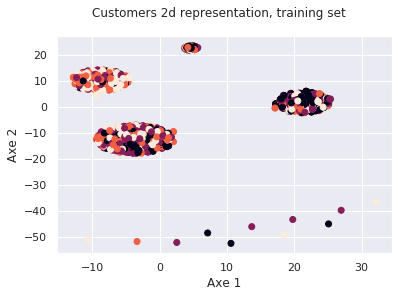

In [71]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [72]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_nca_allfeats_final_tsne.html') 

'clusters_plot_clients_nca_allfeats_final_tsne.html'

# Model with all features and PCA, final representation with tSNE

In [73]:
importlib.reload(sys.modules['functions'])
from functions import *

In [74]:
df_train = df_train_ori
df_test = df_test_ori

In [75]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='PCA', n_dim=200)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [76]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Fit log scaler multiple
Transform log scaler scaler multiple
Fit Min max scaler multiple
Transform Min max scaler multiple
Fit Dimensionality Reductor
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_woodland', 'DescriptionNormalized_word',
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNo

In [77]:
df_train

,HasEverCancelled,TotalPricePerMonth,BoughtTopValueProduct,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,...,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,1.0,0.877446,1.0,0.012337,0.471255,0.453895,0.473793,0.422515,0.477429,0.511299,0.621572,0.503608,0.457640,0.488112,0.409851,0.507055,0.489921,0.535112,0.450099,0.416215,0.433678,0.443110,0.493113,0.412216,0.427219,0.473200,0.432093,0.528716,0.450216,0.459646,0.473048,0.433343,0.488316,0.503164,0.400001,0.584752,0.447438,0.492680,0.517258,0.377823,0.529196,0.459107,0.522877,0.469436,0.504345,0.398998,0.543020,0.429231,0.399796,0.521639,0.542991,0.448954,0.417234,0.431461,0.490515,0.542840,0.510726,0.361016,0.548764,0.425436,0.511753,0.375066,0.496324,0.476174,0.439224,0.479767,0.588310,0.490040,0.387545,0.504146,0.392999,0.414502,0.441010,0.517937,0.472613,0.505581,0.468415,0.561348,0.453965,0.443811,0.579750,0.507491,0.505162,0.522384,0.451964,0.505444,0.475669,0.463194,0.471138,0.428941,0.563994,0.521804,0.501732,0.519740,0.545807,0.399515,0.479424,0.457360,0.552891,0.552132,...,0.442018,0.483510,0.469831,0.555451,0.443640,0.460402,0.409701,0.402955,0.456778,0.516249,0.550767,0.487019,0.398862,0.539100,0.477272,0.455610,0.464136,0.523741,0.486981,0.566659,0.505569,0.421420,0.513580,0.501915,0.431075,0.385072,0.515873,0.499203,0.474613,0.491329,0.545118,0.483152,0.405556,0.417222,0.451988,0.429414,0.505369,0.456888,0.459098,0.492647,0.470510,0.473318,0.407703,0.528234,0.394184,0.417409,0.541471,0.492482,0.453582,0.465603,0.536188,0.409500,0.504954,0.516265,0.484865,0.436857,0.461494,0.485801,0.449288,0.498698,0.494678,0.451859,0.498233,0.463871,0.497176,0.441874,0.495599,0.496479,0.473444,0.542502,0.405203,0.462586,0.430358,0.454841,0.475705,0.448130,0.455027,0.470148,0.508721,0.432294,0.442117,0.450248,0.493644,0.469007,0.445338,0.458374,0.439820,0.449906,0.448205,0.422928,0.475765,0.498462,0.503171,0.520138,0.472351,0.472280,0.456871,0.499050,0.426913,0.469152
1,0.0,0.572415,1.0,0.356103,0.422611,0.371563,0.401206,0.423753,0.459668,0.244695,0.315718,0.324960,0.332577,0.361417,0.446315,0.447542,0.669783,0.790501,0.482164,0.576499,0.752753,0.562993,0.737260,0.470347,0.526157,0.381711,0.560419,0.457615,0.378896,0.394295,0.411293,0.531512,0.580637,0.551046,0.628213,0.473105,0.278695,0.419523,0.597281,0.559024,0.443982,0.486082,0.722544,0.536351,0.164852,0.375486,0.309871,0.571661,0.698559,0.419709,0.153834,0.769936,0.479798,0.650844,0.708143,0.469520,0.160116,0.626756,0.241120,0.358433,0.175175,0.410170,0.425278,0.679632,0.586536,0.522301,0.216822,0.632546,0.435146,0.768242,0.189217,0.355839,0.654483,0.836649,0.607627,0.416430,0.516677,0.243001,0.434406,0.592316,0.654916,0.422913,0.263274,0.487074,0.670438,0.066970,0.270752,0.346566,0.575380,0.687143,0.492310,0.405124,0.750466,0.503628,0.536841,0.306648,0.277527,0.640288,0.915704,0.427103,...,0.367640,0.309116,0.430368,0.614321,0.314971,0.423737,0.557158,0.388584,0.425230,0.503176,0.625818,0.175598,0.461695,0.402608,0.594853,0.414315,0.377087,0.565383,0.599207,0.483363,0.419228,0.439874,0.485338,0.441777,0.559043,0.463116,0.505877,0.291369,0.396165,0.481025,0.518890,0.620306,0.450874,0.694173,0.575584,0.370280,0.169377,0.525288,0.588152,0.363670,0.649533,0.520457,0.494832,0.719235,0.000690,0.522935,0.383923,0.424693,0.163552,0.523089,0.312567,0.472744,0.300414,0.124269,0.497302,0.415230,0.467584,0.328565,0.538658,0.747308,0.404553,0.737778,0.5772

In [78]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4332 entries, 0 to 4331
Columns: 203 entries, HasEverCancelled to 199
dtypes: float64(203)
memory usage: 6.7 MB


In [79]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)

In [80]:
X_transformed[:,1]

array([ 10.128316  , -10.440334  ,  -0.33006346, ...,  10.081147  ,
       -16.101868  ,   2.3950124 ], dtype=float32)

Text(0, 0.5, 'Axe 2')

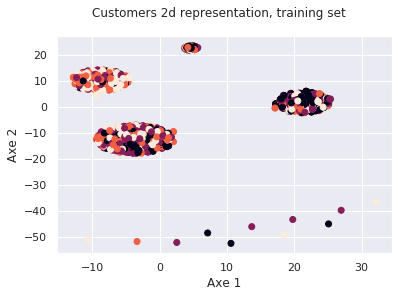

In [81]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [82]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_pca_allfeats_final_tsne.html') 

'clusters_plot_clients_pca_allfeats_final_tsne.html'

# Model with all features and tSNE, final representation with tSNE (best)

In [83]:
importlib.reload(sys.modules['functions'])
from functions import *

In [84]:
df_train = df_train_ori
df_test = df_test_ori

In [85]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='TSNE', n_dim=3)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [86]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Fit log scaler multiple
Transform log scaler scaler multiple
Fit Min max scaler multiple
Transform Min max scaler multiple
Fit Dimensionality Reductor
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_woodland', 'DescriptionNormalized_word',
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNo

In [87]:
df_train

,HasEverCancelled,TotalPricePerMonth,BoughtTopValueProduct,0,1,2
0,1.0,0.877446,1.0,0.783543,0.628913,0.878636
1,0.0,0.572415,1.0,0.727786,0.430184,0.704302
2,0.0,0.474029,0.0,0.741093,0.560714,0.462285
3,0.0,0.707529,1.0,0.648290,0.514565,0.458161
4,0.0,0.330609,0.0,0.759664,0.587738,0.564628
...,...,...,...,...,...,...
4327,0.0,0.286691,0.0,0.747399,0.632402,0.684291
4328,0.0,0.265155,0.0,0.766730,0.647952,0.548147
4329,1.0,0.370964,1.0,0.716419,0.469840,0.643490
4330,0.0,0.505393,1.0,0.727965,0.528250,0.312737


In [88]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4332 entries, 0 to 4331
Data columns (total 6 columns):
HasEverCancelled         4332 non-null float64
TotalPricePerMonth       4332 non-null float64
BoughtTopValueProduct    4332 non-null float64
0                        4332 non-null float64
1                        4332 non-null float64
2                        4332 non-null float64
dtypes: float64(6)
memory usage: 203.2 KB


In [89]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)

In [90]:
X_transformed[:,1]

array([-12.465547,  20.816553, -38.893944, ...,  -5.508614,  51.804184,
       -56.67659 ], dtype=float32)

Text(0, 0.5, 'Axe 2')

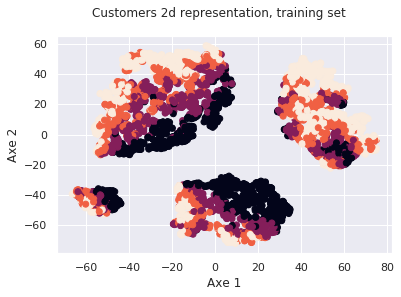

In [91]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [92]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_sne_allfeats_final_tsne.html') 

'clusters_plot_clients_sne_allfeats_final_tsne.html'

# Model with all features and tSNE, BoW not apart from the rest, final representation with tSNE

In [112]:
importlib.reload(sys.modules['functions'])
from functions import *

In [113]:
df_train = df_train_ori
df_test = df_test_ori

In [114]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized', 'TotalPricePerMonth', 'HasEverCancelled', 'BoughtTopValueProduct'], \
                                                        algorithm_to_use='TSNE', n_dim=2)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [115]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Fit log scaler multiple
Transform log scaler scaler multiple
Fit Min max scaler multiple
Transform Min max scaler multiple
Fit Dimensionality Reductor
Features selected (in order): Index(['BoughtTopValueProduct', 'DescriptionNormalized_10',
       'DescriptionNormalized_11', 'DescriptionNormalized_12',
       'DescriptionNormalized_20', 'DescriptionNormalized_24',
       'DescriptionNormalized_36', 'DescriptionNormalized_3d',
       'DescriptionNormalized_50', 'DescriptionNormalized_60',
       ...
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNormalized_your', 'DescriptionNormalized_zinc',
       'HasEverCancelled', '

In [116]:
df_train

,0,1
0,0.485951,0.160709
1,0.510417,0.456580
2,0.196422,0.415772
3,0.153005,0.472337
4,0.383346,0.296471
...,...,...
4327,0.363371,0.242751
4328,0.280691,0.282607
4329,0.479769,0.431286
4330,0.228942,0.604307


In [88]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4332 entries, 0 to 4331
Data columns (total 6 columns):
HasEverCancelled         4332 non-null float64
TotalPricePerMonth       4332 non-null float64
BoughtTopValueProduct    4332 non-null float64
0                        4332 non-null float64
1                        4332 non-null float64
2                        4332 non-null float64
dtypes: float64(6)
memory usage: 203.2 KB


In [89]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)

In [90]:
X_transformed[:,1]

array([-12.465547,  20.816553, -38.893944, ...,  -5.508614,  51.804184,
       -56.67659 ], dtype=float32)

Text(0, 0.5, 'Axe 2')

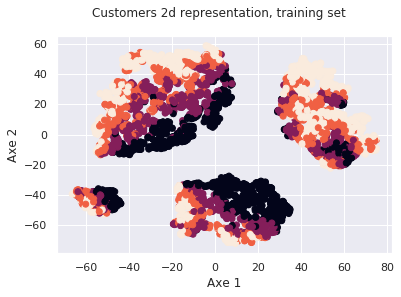

In [91]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [92]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_sne_allfeats_final_tsne.html') 

'clusters_plot_clients_sne_allfeats_final_tsne.html'

# Model with all features and tSNE, final representation with tSNE 3D

In [93]:
importlib.reload(sys.modules['functions'])
from functions import *

In [94]:
df_train = df_train_ori
df_test = df_test_ori

In [95]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='TSNE', n_dim=3)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [96]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Fit log scaler multiple
Transform log scaler scaler multiple
Fit Min max scaler multiple
Transform Min max scaler multiple
Fit Dimensionality Reductor
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_woodland', 'DescriptionNormalized_word',
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNo

In [97]:
df_train

,HasEverCancelled,TotalPricePerMonth,BoughtTopValueProduct,0,1,2
0,1.0,0.877446,1.0,0.783543,0.628913,0.878636
1,0.0,0.572415,1.0,0.727786,0.430184,0.704302
2,0.0,0.474029,0.0,0.741093,0.560714,0.462285
3,0.0,0.707529,1.0,0.648290,0.514565,0.458161
4,0.0,0.330609,0.0,0.759664,0.587738,0.564628
...,...,...,...,...,...,...
4327,0.0,0.286691,0.0,0.747399,0.632402,0.684291
4328,0.0,0.265155,0.0,0.766730,0.647952,0.548147
4329,1.0,0.370964,1.0,0.716419,0.469840,0.643490
4330,0.0,0.505393,1.0,0.727965,0.528250,0.312737


In [98]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4332 entries, 0 to 4331
Data columns (total 6 columns):
HasEverCancelled         4332 non-null float64
TotalPricePerMonth       4332 non-null float64
BoughtTopValueProduct    4332 non-null float64
0                        4332 non-null float64
1                        4332 non-null float64
2                        4332 non-null float64
dtypes: float64(6)
memory usage: 203.2 KB


In [99]:
tsne = TSNE(n_components=3, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)

In [100]:
X_transformed[:,1]

array([-7.9212937,  3.8351228, -2.1941373, ..., -7.4698176, 13.077991 ,
        4.946701 ], dtype=float32)

In [101]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter3d(x = X_transformed[:,0], y = X_transformed[:,1], z = X_transformed[:,2],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 3 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_sne_allfeats_final_tsne_3d.html') 

'clusters_plot_clients_sne_allfeats_final_tsne_3d.html'

# Model with bow features + TotalPricePerMonth and NCA, final representation with tSNE

In [102]:
importlib.reload(sys.modules['functions'])
from functions import *

In [103]:
df_train = df_train_ori
df_test = df_test_ori

In [104]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized', 'TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='NCA', n_dim=200, labels_featurename='TotalPricePerMonth')),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [105]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Fit log scaler multiple
Transform log scaler scaler multiple
Fit Min max scaler multiple
Transform Min max scaler multiple
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_word', 'DescriptionNormalized_world',
       'DescriptionNormalized_wrap', 'DescriptionNormalized_wreath',
       'DescriptionNormalized_writing', 'DescriptionNormalized_yellow',
       'DescriptionNormalized_you', 'DescriptionNormalized_your',
       'DescriptionNormalized_zinc', 'TotalPricePerMo

In [106]:
df_train

,TotalPricePerMonth,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,...,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,0.877446,0.012337,0.471255,0.453895,0.473793,0.422515,0.477429,0.511299,0.621572,0.503608,0.457640,0.488112,0.409851,0.507055,0.489921,0.535112,0.450099,0.416215,0.433678,0.443110,0.493113,0.412216,0.427219,0.473200,0.432093,0.528716,0.450216,0.459646,0.473048,0.433343,0.488316,0.503164,0.400001,0.584752,0.447438,0.492680,0.517258,0.377823,0.529196,0.459107,0.522877,0.469436,0.504345,0.398998,0.543020,0.429231,0.399796,0.521639,0.542991,0.448954,0.417234,0.431461,0.490515,0.542840,0.510726,0.361016,0.548764,0.425436,0.511753,0.375066,0.496324,0.476174,0.439224,0.479767,0.588310,0.490040,0.387545,0.504146,0.392999,0.414502,0.441010,0.517937,0.472613,0.505581,0.468415,0.561348,0.453965,0.443811,0.579750,0.507491,0.505162,0.522384,0.451964,0.505444,0.475669,0.463194,0.471138,0.428941,0.563994,0.521804,0.501732,0.519740,0.545807,0.399515,0.479424,0.457360,0.552891,0.552132,0.498420,0.459838,...,0.442018,0.483510,0.469831,0.555451,0.443640,0.460402,0.409701,0.402955,0.456778,0.516249,0.550767,0.487019,0.398862,0.539100,0.477272,0.455610,0.464136,0.523741,0.486981,0.566659,0.505569,0.421420,0.513580,0.501915,0.431075,0.385072,0.515873,0.499203,0.474613,0.491329,0.545118,0.483152,0.405556,0.417222,0.451988,0.429414,0.505369,0.456888,0.459098,0.492647,0.470510,0.473318,0.407703,0.528234,0.394184,0.417409,0.541471,0.492482,0.453582,0.465603,0.536188,0.409500,0.504954,0.516265,0.484865,0.436857,0.461494,0.485801,0.449288,0.498698,0.494678,0.451859,0.498233,0.463871,0.497176,0.441874,0.495599,0.496479,0.473444,0.542502,0.405203,0.462586,0.430358,0.454841,0.475705,0.448130,0.455027,0.470148,0.508721,0.432294,0.442117,0.450248,0.493644,0.469007,0.445338,0.458374,0.439820,0.449906,0.448205,0.422928,0.475765,0.498462,0.503171,0.520138,0.472351,0.472280,0.456871,0.499050,0.426913,0.469152
1,0.572415,0.356103,0.422611,0.371563,0.401206,0.423753,0.459668,0.244695,0.315718,0.324960,0.332577,0.361417,0.446315,0.447542,0.669783,0.790501,0.482164,0.576499,0.752753,0.562993,0.737260,0.470347,0.526157,0.381711,0.560419,0.457615,0.378896,0.394295,0.411293,0.531512,0.580637,0.551046,0.628213,0.473105,0.278695,0.419523,0.597281,0.559024,0.443982,0.486082,0.722544,0.536351,0.164852,0.375486,0.309871,0.571661,0.698559,0.419709,0.153834,0.769936,0.479798,0.650844,0.708143,0.469520,0.160116,0.626756,0.241120,0.358433,0.175175,0.410170,0.425278,0.679632,0.586536,0.522301,0.216822,0.632546,0.435146,0.768242,0.189217,0.355839,0.654483,0.836649,0.607627,0.416430,0.516677,0.243001,0.434406,0.592316,0.654916,0.422913,0.263274,0.487074,0.670438,0.066970,0.270752,0.346566,0.575380,0.687143,0.492310,0.405124,0.750466,0.503628,0.536841,0.306648,0.277527,0.640288,0.915704,0.427103,0.335526,0.349815,...,0.367640,0.309116,0.430368,0.614321,0.314971,0.423737,0.557158,0.388584,0.425230,0.503176,0.625818,0.175598,0.461695,0.402608,0.594853,0.414315,0.377087,0.565383,0.599207,0.483363,0.419228,0.439874,0.485338,0.441777,0.559043,0.463116,0.505877,0.291369,0.396165,0.481025,0.518890,0.620306,0.450874,0.694173,0.575584,0.370280,0.169377,0.525288,0.588152,0.363670,0.649533,0.520457,0.494832,0.719235,0.000690,0.522935,0.383923,0.424693,0.163552,0.523089,0.312567,0.472744,0.300414,0.124269,0.497302,0.415230,0.467584,0.328565,0.538658,0.747308,0.404553,0.737778,0.577275,0.317186,0

In [107]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4332 entries, 0 to 4331
Columns: 201 entries, TotalPricePerMonth to 199
dtypes: float64(201)
memory usage: 6.6 MB


In [108]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)

In [109]:
X_transformed[:,1]

array([ -3.402222 ,  -1.4547541, -14.010796 , ...,   6.6002717,
       -47.472893 ,  -1.363583 ], dtype=float32)

Text(0, 0.5, 'Axe 2')

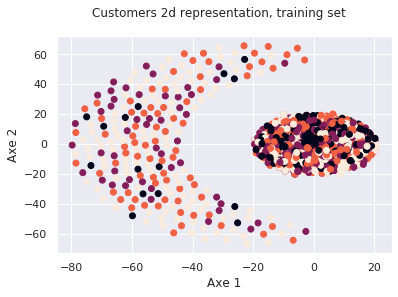

In [110]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [111]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_nca_bowandtotalpricepermonthfeats_final_tsne.html') 

'clusters_plot_clients_nca_bowandtotalpricepermonthfeats_final_tsne.html'

# Model with tSNE, then clustering algorithm KMeans

In [138]:
importlib.reload(sys.modules['functions'])
from functions import *

In [123]:
df_train = df_train_ori
df_test = df_test_ori

In [124]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='TSNE', n_dim=3)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [125]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Fit log scaler multiple
Transform log scaler scaler multiple
Fit Min max scaler multiple
Transform Min max scaler multiple
Fit Dimensionality Reductor
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_woodland', 'DescriptionNormalized_word',
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNo

In [126]:
df_train

,HasEverCancelled,TotalPricePerMonth,BoughtTopValueProduct,0,1,2
0,1.0,0.877446,1.0,0.783543,0.628913,0.878636
1,0.0,0.572415,1.0,0.727786,0.430184,0.704302
2,0.0,0.474029,0.0,0.741093,0.560714,0.462285
3,0.0,0.707529,1.0,0.648290,0.514565,0.458161
4,0.0,0.330609,0.0,0.759664,0.587738,0.564628
...,...,...,...,...,...,...
4327,0.0,0.286691,0.0,0.747399,0.632402,0.684291
4328,0.0,0.265155,0.0,0.766730,0.647952,0.548147
4329,1.0,0.370964,1.0,0.716419,0.469840,0.643490
4330,0.0,0.505393,1.0,0.727965,0.528250,0.312737


In [129]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df_train)
                for k in range(1, 50)]

In [130]:
labels_test_per_k = [model.predict(df_test) for model in kmeans_per_k[1:]]

In [131]:
silhouette_scores = [silhouette_score(df_train, model.labels_)
                     for model in kmeans_per_k[1:]]

In [135]:
silhouette_scores_test = [silhouette_score(df_test, labels_test) for labels_test in labels_test_per_k]

In [163]:
gini_mean_score_per_k_train = []

for model in kmeans_per_k[1:]:
    unique_labels = np.unique(model.labels_)
    
    gini_sum = 0
    for unique_label in unique_labels:
        gini_sum += gini(df_train['TotalPricePerMonth'][model.labels_ == unique_label].to_numpy())
        
    gini_sum = gini_sum / len(unique_labels)
    
    gini_mean_score_per_k_train.append(gini_sum)

    
gini_mean_score_per_k_test = []

for labels_test in labels_test_per_k:
    unique_labels = np.unique(labels_test)
    
    gini_sum = 0
    for unique_label in unique_labels:
        gini_sum += gini(df_test['TotalPricePerMonth'][labels_test == unique_label].to_numpy())
        
    gini_sum = gini_sum / len(unique_labels)
    
    gini_mean_score_per_k_test.append(gini_sum)    
    

In [210]:
entropy_mean_score_per_k_train = []

for model in kmeans_per_k[1:]:
    unique_labels = np.unique(model.labels_)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(df_train['TotalPricePerMonth'][model.labels_ == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_train.append(entropy_sum)

    
entropy_mean_score_per_k_test = []

for labels_test in labels_test_per_k:
    unique_labels = np.unique(labels_test)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(df_test['TotalPricePerMonth'][labels_test == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_test.append(entropy_sum)    
    

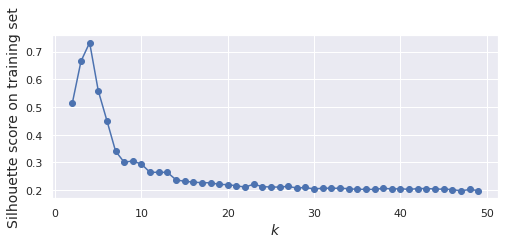

In [133]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

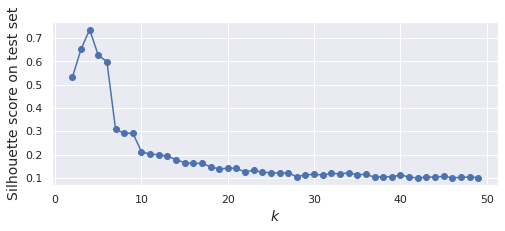

In [136]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [214]:
print('Gini before clustering :')
gini(df_train['TotalPricePerMonth'].to_numpy())

Gini before clustering :


0.14231138191824186

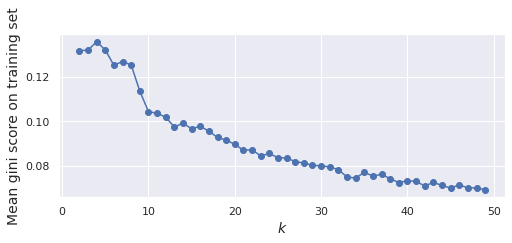

In [166]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), gini_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean gini score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

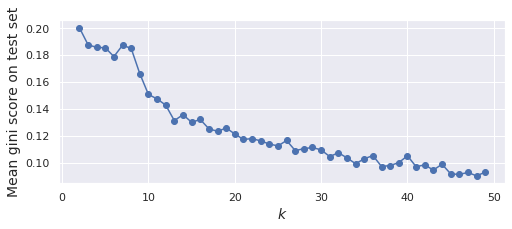

In [167]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), gini_mean_score_per_k_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean gini score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [209]:
print('Entropy before clustering :')
entropy(df_train['TotalPricePerMonth'])

8.340339103018163

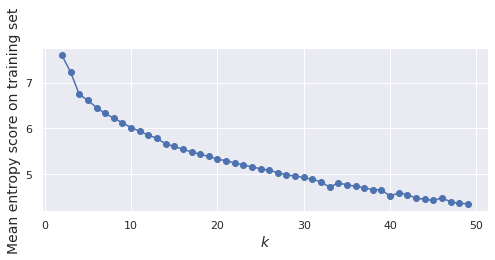

In [215]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

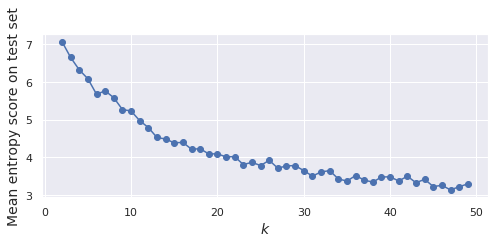

In [216]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

# Model with tSNE, then clustering algorithm Ward
No visualisation on test set because AgglomerativeClustering has no predict function, only fit_predict

In [168]:
clusterer_per_k = [AgglomerativeClustering(n_clusters=k, affinity='euclidean').fit(df_train) for k in range(1,50)]

In [170]:
silhouette_scores = [silhouette_score(df_train, model.labels_)
                     for model in clusterer_per_k[1:]]

In [171]:
gini_mean_score_per_k_train = []

for model in clusterer_per_k[1:]:
    unique_labels = np.unique(model.labels_)
    
    gini_sum = 0
    for unique_label in unique_labels:
        gini_sum += gini(df_train['TotalPricePerMonth'][model.labels_ == unique_label].to_numpy())
        
    gini_sum = gini_sum / len(unique_labels)
    
    gini_mean_score_per_k_train.append(gini_sum)


    

In [217]:
entropy_mean_score_per_k_train = []

for model in clusterer_per_k[1:]:
    unique_labels = np.unique(model.labels_)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(df_train['TotalPricePerMonth'][model.labels_ == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_train.append(entropy_sum)

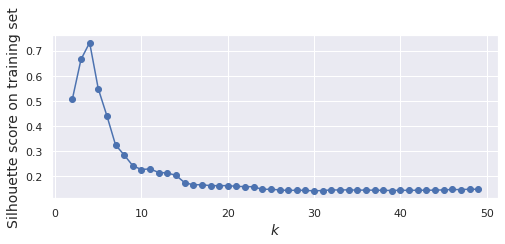

In [172]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

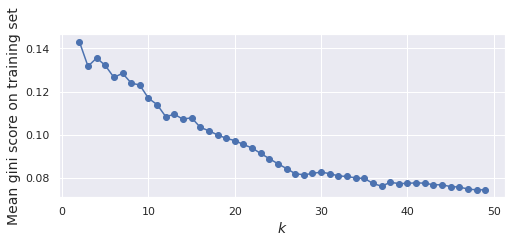

In [173]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), gini_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean gini score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [221]:
print('Entropy before clustering :')
entropy(df_train['TotalPricePerMonth'])

Entropy before clustering :


8.340339103018163

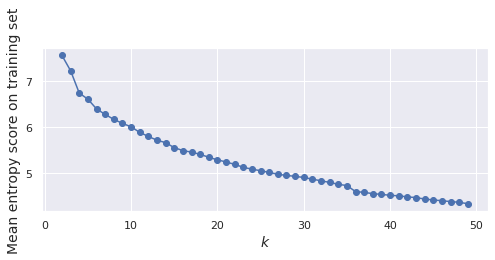

In [219]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

# Model with tSNE, then clustering algorithm Ward, distance threshold
No visualisation on test set because AgglomerativeClustering has no predict function, only fit_predict

In [253]:
np.unique(AgglomerativeClustering(distance_threshold=1, n_clusters=None, affinity='euclidean').fit(df_train).labels_)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55])

In [271]:
clusterer_ward_per_thr = [AgglomerativeClustering(distance_threshold=thr, n_clusters=None, affinity='euclidean').fit(df_train) for thr in reversed(range(0,12))]

In [234]:
np.unique(clusterer_ward.labels_)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [262]:
clusterer_ward_per_thr

[]

In [272]:
entropy_mean_score_per_k_train = []

for model in clusterer_ward_per_thr[1:]:
    unique_labels = np.unique(model.labels_)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(df_train['TotalPricePerMonth'][model.labels_ == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_train.append(entropy_sum)

/home/francois/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2614: RuntimeWarning:

invalid value encountered in true_divide



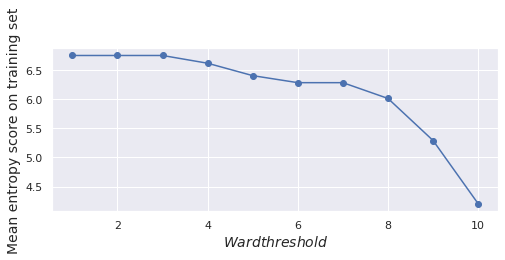

In [276]:
plt.figure(figsize=(8, 3))
plt.plot(range(1,12), entropy_mean_score_per_k_train, "bo-")
plt.xlabel("$Ward threshold$", fontsize=14)
plt.ylabel("Mean entropy score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

# => Around 50 clusters => entropy of TotalPrice around 4.5

# Annex

## Display some data

In [26]:
df_nocancel = df[df['InvoiceNo'].str.startswith('C') == False]
df_nocancel.reset_index(inplace=True)

df_gbproduct = df_nocancel[['StockCode', 'TotalPrice']].groupby('StockCode').sum()['TotalPrice']

In [27]:
df_nocancel.head(2)

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,DescriptionNormalized,InvoiceMonth
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,WHITE HANGING HEART T-LIGHT HOLDER,2010-12-01 00:00:00
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,WHITE METAL LANTERN,2010-12-01 00:00:00


In [28]:
df_nocancel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391328 entries, 0 to 391327
Data columns (total 12 columns):
index                    391328 non-null int64
InvoiceNo                391328 non-null object
StockCode                391328 non-null object
Description              391328 non-null object
Quantity                 391328 non-null int64
InvoiceDate              391328 non-null object
UnitPrice                391328 non-null float64
CustomerID               391328 non-null object
Country                  391328 non-null object
TotalPrice               391328 non-null float64
DescriptionNormalized    391328 non-null object
InvoiceMonth             391328 non-null object
dtypes: float64(2), int64(2), object(8)
memory usage: 35.8+ MB


In [29]:
invoice_dates = pd.to_datetime(df_nocancel["InvoiceDate"], format="%Y-%m-%d ")

In [30]:
invoice_dates = pd.to_datetime(df_nocancel["InvoiceDate"])

In [31]:
np.maximum((pd.to_datetime('2011-12-09 12:50:00') - invoice_dates) / (np.timedelta64(1, "M")), 1)[123456]

6.997862150945377

In [32]:
df_gbcustom_firstorder = df_nocancel[['CustomerID', 'InvoiceDate']].groupby('CustomerID').min()

In [33]:
df_nocancel[['CustomerID', 'InvoiceDate']].groupby('CustomerID').min()['InvoiceDate']

CustomerID
12346    2011-01-18 10:01:00
12347    2010-12-07 14:57:00
12348    2010-12-16 19:09:00
12349    2011-11-21 09:51:00
12350    2011-02-02 16:01:00
                ...         
18280    2011-03-07 09:52:00
18281    2011-06-12 10:53:00
18282    2011-08-05 13:35:00
18283    2011-01-06 14:14:00
18287    2011-05-22 10:39:00
Name: InvoiceDate, Length: 4336, dtype: object

In [34]:
(\
   pd.to_datetime('2011-12-09 12:50:00')\
   - pd.to_datetime(df_nocancel[['CustomerID', 'InvoiceDate']].groupby('CustomerID').min()['InvoiceDate'])
)\
  / (np.timedelta64(1, "M"))

CustomerID
12346    10.681693
12347    12.054845
12348    11.753401
12349     0.595472
12350    10.180656
           ...    
18280     9.104864
18281     5.916549
18282     4.138689
18283    11.070179
18287     6.606821
Name: InvoiceDate, Length: 4336, dtype: float64

In [35]:
# Number of months between first order date and last date of the dataset
series_gbclient_nbmonths = np.maximum(\
(
   (
   pd.to_datetime('2011-12-09 12:50:00')\
   - pd.to_datetime(df_nocancel[['CustomerID', 'InvoiceDate']].groupby('CustomerID').min()['InvoiceDate'])
   )\
    / (np.timedelta64(1, "M"))
), 1)

In [36]:
df_nocancel[['CustomerID', ]]

,CustomerID
0,17850
1,17850
2,17850
3,17850
4,17850
...,...
391323,12680
391324,12680
391325,12680
391326,12680


In [37]:
df_gbcustom_firstorder

,InvoiceDate
CustomerID,
12346,2011-01-18 10:01:00
12347,2010-12-07 14:57:00
12348,2010-12-16 19:09:00
12349,2011-11-21 09:51:00
12350,2011-02-02 16:01:00
...,...
18280,2011-03-07 09:52:00
18281,2011-06-12 10:53:00
18282,2011-08-05 13:35:00


In [38]:
df_nocancel[df_nocancel['CustomerID'] == '18281'].sort_values(by='InvoiceDate', ascending=True)

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,DescriptionNormalized,InvoiceMonth
153118,156809,556464,22037,ROBOT BIRTHDAY CARD,12,2011-06-12 10:53:00,0.42,18281,United Kingdom,5.04,ROBOT BIRTHDAY CARD,2011-06-01 00:00:00
153119,156810,556464,22716,CARD CIRCUS PARADE,12,2011-06-12 10:53:00,0.42,18281,United Kingdom,5.04,CARD CIRCUS PARADE,2011-06-01 00:00:00
153120,156811,556464,22028,PENNY FARTHING BIRTHDAY CARD,12,2011-06-12 10:53:00,0.42,18281,United Kingdom,5.04,PENNY FARTHING BIRTHDAY CARD,2011-06-01 00:00:00
153121,156812,556464,23007,SPACEBOY BABY GIFT SET,1,2011-06-12 10:53:00,16.95,18281,United Kingdom,16.95,SPACEBOY BABY GIFT SET,2011-06-01 00:00:00
153122,156813,556464,23008,DOLLY GIRL BABY GIFT SET,1,2011-06-12 10:53:00,16.95,18281,United Kingdom,16.95,DOLLY GIRL BABY GIFT SET,2011-06-01 00:00:00
153123,156814,556464,23209,LUNCH BAG DOILEY PATTERN,10,2011-06-12 10:53:00,1.65,18281,United Kingdom,16.50,LUNCH BAG VINTAGE DOILY,2011-06-01 00:00:00
153124,156815,556464,22467,GUMBALL COAT RACK,6,2011-06-12 10:53:00,2.55,18281,United Kingdom,15.30,GUMBALL COAT RACK,2011-06-01 00:00:00


In [39]:
invoice_dates[2000:2010]

2000   2010-12-02 09:43:00
2001   2010-12-02 09:43:00
2002   2010-12-02 09:43:00
2003   2010-12-02 09:43:00
2004   2010-12-02 09:43:00
2005   2010-12-02 09:43:00
2006   2010-12-02 09:43:00
2007   2010-12-02 09:43:00
2008   2010-12-02 09:44:00
2009   2010-12-02 09:44:00
Name: InvoiceDate, dtype: datetime64[ns]

In [40]:
df_nocancel.loc[2000:2010,'InvoiceDate']

2000    2010-12-02 09:43:00
2001    2010-12-02 09:43:00
2002    2010-12-02 09:43:00
2003    2010-12-02 09:43:00
2004    2010-12-02 09:43:00
2005    2010-12-02 09:43:00
2006    2010-12-02 09:43:00
2007    2010-12-02 09:43:00
2008    2010-12-02 09:44:00
2009    2010-12-02 09:44:00
2010    2010-12-02 09:44:00
Name: InvoiceDate, dtype: object

In [41]:
df_nocancel.loc[100000:100010,'InvoiceMonth']

100000    2011-04-01 00:00:00
100001    2011-04-01 00:00:00
100002    2011-04-01 00:00:00
100003    2011-04-01 00:00:00
100004    2011-04-01 00:00:00
100005    2011-04-01 00:00:00
100006    2011-04-01 00:00:00
100007    2011-04-01 00:00:00
100008    2011-04-01 00:00:00
100009    2011-04-01 00:00:00
100010    2011-04-01 00:00:00
Name: InvoiceMonth, dtype: object

In [42]:
df[df['InvoiceNo'].str.startswith('C') == True]['CustomerID'].unique()

array(['14527', '15311', '17548', ..., '12985', '15951', '16446'],
      dtype=object)

In [43]:
# Product codes that contain chars instead of numbers
df[df['StockCode'].str.isalpha()]['StockCode'].unique()

array(['D'], dtype=object)

# For debug / test (clean code is in functions.py)

In [44]:
df_train = df_train_ori
df_test = df_test_ori

In [45]:
df_train.head(6)

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,DescriptionNormalized,InvoiceMonth
0,11503,537781,21377,SMALL CAMPHOR WOOD FIELD MUSHROOM,1,2010-12-08 12:46:00,1.65,17341,United Kingdom,1.65,SMALL CAMPHOR WOOD FIELD MUSHROOM,2010-12-01 00:00:00
1,40887,541855,21947,SET OF 6 HEART CHOPSTICKS,1,2011-01-23 14:59:00,1.25,13742,United Kingdom,1.25,SET OF 6 HEART CHOPSTICKS,2011-01-01 00:00:00
2,103799,549646,85031A,ROMANTIC IMAGES SCRAP BOOK SET,6,2011-04-11 11:51:00,1.25,12982,United Kingdom,7.50,ROMANTIC IMAGES SCRAP BOOK SET,2011-04-01 00:00:00
3,372911,578856,23535,WALL ART BICYCLE SAFETY,4,2011-11-27 11:18:00,5.95,17769,United Kingdom,23.80,WALL ART BICYCLE SAFETY,2011-11-01 00:00:00
4,297823,571747,23396,LE JARDIN BOTANIQUE CUSHION COVER,4,2011-10-19 10:59:00,3.75,13849,United Kingdom,15.00,LE JARDIN BOTANIQUE CUSHION COVER,2011-10-01 00:00:00
5,359556,577535,21098,CHRISTMAS TOILET ROLL,3,2011-11-20 14:07:00,1.25,14071,United Kingdom,3.75,CHRISTMAS TOILET ROLL,2011-11-01 00:00:00


In [46]:
df_train

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,DescriptionNormalized,InvoiceMonth
0,11503,537781,21377,SMALL CAMPHOR WOOD FIELD MUSHROOM,1,2010-12-08 12:46:00,1.65,17341,United Kingdom,1.65,SMALL CAMPHOR WOOD FIELD MUSHROOM,2010-12-01 00:00:00
1,40887,541855,21947,SET OF 6 HEART CHOPSTICKS,1,2011-01-23 14:59:00,1.25,13742,United Kingdom,1.25,SET OF 6 HEART CHOPSTICKS,2011-01-01 00:00:00
2,103799,549646,85031A,ROMANTIC IMAGES SCRAP BOOK SET,6,2011-04-11 11:51:00,1.25,12982,United Kingdom,7.50,ROMANTIC IMAGES SCRAP BOOK SET,2011-04-01 00:00:00
3,372911,578856,23535,WALL ART BICYCLE SAFETY,4,2011-11-27 11:18:00,5.95,17769,United Kingdom,23.80,WALL ART BICYCLE SAFETY,2011-11-01 00:00:00
4,297823,571747,23396,LE JARDIN BOTANIQUE CUSHION COVER,4,2011-10-19 10:59:00,3.75,13849,United Kingdom,15.00,LE JARDIN BOTANIQUE CUSHION COVER,2011-10-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
359915,128343,552843,22692,DOORMAT WELCOME TO OUR HOME,1,2011-05-11 14:37:00,7.95,14649,United Kingdom,7.95,DOORMAT WELCOME TO OUR HOME,2011-05-01 00:00:00
359916,272049,569401,23356,LOVE HOT WATER BOTTLE,3,2011-10-04 08:56:00,5.95,15111,United Kingdom,17.85,LOVE HOT WATER BOTTLE,2011-10-01 00:00:00
359917,225276,564554,23280,FOLDING BUTTERFLY MIRROR HOT PINK,1,2011-08-25 19:39:00,0.83,17189,United Kingdom,0.83,FOLDING BUTTERFLY MIRROR HOT PINK,2011-08-01 00:00:00
359918,302898,572274,22423,REGENCY CAKESTAND 3 TIER,16,2011-10-21 16:48:00,10.95,14031,United Kingdom,175.20,REGENCY CAKESTAND 3 TIER,2011-10-01 00:00:00


In [47]:
df_train_nocancel = df_train[df_train['InvoiceNo'].str.startswith('C') == False]
df_train_nocancel.reset_index(inplace=True)

In [48]:
feat_list = ['CustomerID', 'TotalPrice']
feat_list_bow = [col for col in df_train_nocancel if col.startswith('DescriptionNormalized_')]
feat_list.extend(feat_list_bow)

In [49]:
feat_list

['CustomerID', 'TotalPrice']

In [50]:
df_train_gbcust_nocancel = df_train_nocancel[feat_list].groupby('CustomerID').sum()

In [51]:
df_train_gbcust_nocancel[feat_list_bow] = df_train_gbcust_nocancel[feat_list_bow].clip(upper=1)

In [52]:
df_train_gbcust_nocancel

,TotalPrice
CustomerID,
12346,77183.60
12347,3956.22
12348,1416.84
12349,1292.19
12350,279.40
...,...
18280,156.90
18281,80.82
18282,173.01


In [53]:
# Number of months between first order date and last date of the dataset
series_train_gbclient_nbmonths = np.maximum(\
(
   (
   pd.to_datetime('2011-12-09 12:50:00')\
   - pd.to_datetime(df_train_nocancel[['CustomerID', 'InvoiceDate']].groupby('CustomerID').min()['InvoiceDate'])
   )\
    / (np.timedelta64(1, "M"))
), 1)

In [54]:
series_train_gbclient_nbmonths

CustomerID
12346    10.681693
12347    12.054845
12348    11.753401
12349     1.000000
12350    10.180656
           ...    
18280     9.104864
18281     5.916549
18282     4.138689
18283    11.070179
18287     6.606821
Name: InvoiceDate, Length: 4332, dtype: float64

In [55]:
df_train_gbcust_nocancel['TotalPrice'] 

CustomerID
12346    77183.60
12347     3956.22
12348     1416.84
12349     1292.19
12350      279.40
           ...   
18280      156.90
18281       80.82
18282      173.01
18283     1837.51
18287     1684.52
Name: TotalPrice, Length: 4332, dtype: float64

In [56]:
df_train_gbcust_nocancel['TotalPrice'] = df_train_gbcust_nocancel['TotalPrice'] / series_train_gbclient_nbmonths

In [57]:
df_train_gbcust_nocancel

,TotalPrice
CustomerID,
12346,7225.783259
12347,328.185062
12348,120.547233
12349,1292.190000
12350,27.444203
...,...
18280,17.232547
18281,13.659991
18282,41.803096


In [58]:
df_train

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,DescriptionNormalized,InvoiceMonth
0,11503,537781,21377,SMALL CAMPHOR WOOD FIELD MUSHROOM,1,2010-12-08 12:46:00,1.65,17341,United Kingdom,1.65,SMALL CAMPHOR WOOD FIELD MUSHROOM,2010-12-01 00:00:00
1,40887,541855,21947,SET OF 6 HEART CHOPSTICKS,1,2011-01-23 14:59:00,1.25,13742,United Kingdom,1.25,SET OF 6 HEART CHOPSTICKS,2011-01-01 00:00:00
2,103799,549646,85031A,ROMANTIC IMAGES SCRAP BOOK SET,6,2011-04-11 11:51:00,1.25,12982,United Kingdom,7.50,ROMANTIC IMAGES SCRAP BOOK SET,2011-04-01 00:00:00
3,372911,578856,23535,WALL ART BICYCLE SAFETY,4,2011-11-27 11:18:00,5.95,17769,United Kingdom,23.80,WALL ART BICYCLE SAFETY,2011-11-01 00:00:00
4,297823,571747,23396,LE JARDIN BOTANIQUE CUSHION COVER,4,2011-10-19 10:59:00,3.75,13849,United Kingdom,15.00,LE JARDIN BOTANIQUE CUSHION COVER,2011-10-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
359915,128343,552843,22692,DOORMAT WELCOME TO OUR HOME,1,2011-05-11 14:37:00,7.95,14649,United Kingdom,7.95,DOORMAT WELCOME TO OUR HOME,2011-05-01 00:00:00
359916,272049,569401,23356,LOVE HOT WATER BOTTLE,3,2011-10-04 08:56:00,5.95,15111,United Kingdom,17.85,LOVE HOT WATER BOTTLE,2011-10-01 00:00:00
359917,225276,564554,23280,FOLDING BUTTERFLY MIRROR HOT PINK,1,2011-08-25 19:39:00,0.83,17189,United Kingdom,0.83,FOLDING BUTTERFLY MIRROR HOT PINK,2011-08-01 00:00:00
359918,302898,572274,22423,REGENCY CAKESTAND 3 TIER,16,2011-10-21 16:48:00,10.95,14031,United Kingdom,175.20,REGENCY CAKESTAND 3 TIER,2011-10-01 00:00:00


In [59]:
custid_cancelled = df_train[df_train['InvoiceNo'].str.startswith('C') == True]['CustomerID'].unique()